**Simplex**

**Trabalho 2 de Métodos Númericos**

Alunos:

Gabriel Vasconcelos Fruet - 537618

Pedro Leinos Falcão da Cunha - 542114

Kelvin Leandro Martins - 540006

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib as mplt

from matplotlib import pyplot as plt
from matplotlib import patches as ptc

MAXTEXT = r'\max_{\substack{Ax \le b \\ x \ge 0}}'

In [ ]:
def formulate_linear_program():
  n_ineq = int(input('Number of inequalities: '))
  n_var = int(input('Number of variables: '))

  As = []
  bs = []
  for i in range(n_ineq):
    print(f'Enter the {i}th inequality.')
    As.append([float(c) for c in input('Enter the a_i coeficients spaced: ').split(' ')])
    bs.append(float(input('Enter the b value: ')))


  z = [float(c) for c in input('Enter the objective function coeficients spaced: ').split(' ')]

  return np.array(As), np.array(bs), np.array(z)

In [ ]:
from IPython.display import display, Math, Latex, HTML

def coef_line(x, var_names):
  equation = ''
  for j, (aj,var_name) in enumerate(zip(x, var_names)):
    if aj == 0:
      continue
    if j != 0:
      signal = '+' if aj >= 0 else '-'
      equation += f"{signal} {abs(aj)} {var_name}"
    else:
      equation += f"{aj} {var_name}"
  return equation

def show_std_lp(A,b,z, var_names=None):
  lines = []
  _, m = A.shape
  if var_names is None:
    var_names = [f'x_{i}' for i in range(m)]

  for Ai, bi in zip(A,b):
    line = coef_line(Ai, var_names)
    line += f' \\le {bi}'
    lines.append(line)


  for line in lines:
    display(Latex(line))

  print('Maximize the objective function: ')
  line = coef_line(z, var_names)
  line += ' = z'
  display(Latex(line))

In [ ]:
class Simplex:
  @staticmethod
  def turn_pivot_to_basic(A,i,j):
    A = A.copy()
    pivot = A[i,j]
    A[i] /= pivot

    column = A[:, j].copy()
    column[i] = 0

    coef = -column

    pivot_row = A[i]

    A += pivot_row * coef[:, np.newaxis]
    return  A

  @staticmethod
  def construct_tableau(A,b,z):
    n = len(A)
    tableau = np.c_[
        np.r_[A,[-z]],
        np.eye(n+1),
        np.r_[b,0]
    ]
    return tableau

  @staticmethod
  def show_tableau(tableau):
    n,m = tableau.shape
    return pd.DataFrame(data=tableau,
                        columns=[*[f'x{i}' for i in range(m-n-1)], *[f's{i}' for i in range(n-1)], 'z', 'b'],
                        index=[*[f'{i}th constraint' for i in range(n-1)], 'objective function']
                        )

  @staticmethod
  def find_pivot(tableau):
    n,m = tableau.shape
    j = np.argmin(tableau[-1])
    pivot_column = tableau[:-1, j]
    b = tableau[:-1, -1]
    indicators = b / pivot_column
    indicators[indicators <= 0] = np.inf
    i = np.argmin(indicators)
    return i,j

  @staticmethod
  def is_optimal(tableau):
    n,m = tableau.shape
    return np.all(tableau[-1] >= 0)

  @staticmethod
  def solve(A,b,z, return_tableau=False, show_tableau=True):
    tableau = Simplex.construct_tableau(A,b,z)
    x,s,z,tab = Simplex._solve(tableau)
    if show_tableau:
      print(Simplex.show_tableau(tab))
    return x,s,z

  @staticmethod
  def _solve(tableau, i=0):
    S = Simplex
    if S.is_optimal(tableau):
      return S.find_optimal(tableau)
    else:
      i,j = S.find_pivot(tableau)
      tableau = S.turn_pivot_to_basic(tableau,i,j)
      return S._solve(tableau,i=i+1)

  @staticmethod
  def find_optimal(tableau):
    S = Simplex
    n,m = tableau.shape
    if not S.is_optimal(tableau):
      raise Exception('Its impossible to find an optimal solution of an non-optimal tableau.')

    vars = tableau[:, :-1]
    b = tableau[:, -1]
    var_as_row = vars.T
    basic_variables_columns_mask = np.sum(var_as_row != 0, axis=-1) == 1
    basic_variables_rows_mask = np.argmax(vars[:, basic_variables_columns_mask],axis=0)

    solution = np.zeros(m-1)
    solution[basic_variables_columns_mask] = b[basic_variables_rows_mask]

    slack_var_no = n - 1
    var_no = m - 2 - slack_var_no

    var_sol = solution[:var_no]
    slack_var_sol = solution[var_no:-1]
    optimal_value = solution[-1]

    return var_sol, slack_var_sol, optimal_value, tableau



# **Questão 1**
Uma companhia faz dois tipos de produto, A e B. Esses produtos são fabricados
durante 40 horas de trabalho por semana e, então, despachados no final de semana.

Eles vão requerer respectivamente 20 e 5 kg de matéria-prima para cada quilo de
produto, e a companhia dispõe de 9500 kg de matéria-prima por semana. Apenas
um produto pode ser fabricado por vez, com o tempo de produção de cada um de
0,04 e 0,12 hora respectivamente. A fábrica pode armazenar apenas 550 kg de
produto total por semana. Finalmente, a companhia tem lucro de R\$ 45,00 e R\$
20,00 em cada unidade de A e B, respectivamente. Cada unidade de produto é
equivalente a um quilo.


## a) Escreva um programa de programação linear para maximizar o lucro;

$20kg \cdot A + 5kg \cdot B \le 9500$

$0.04h \cdot A + 0.12h \cdot B \le 40h$

$1kg \cdot A + 1kg \cdot B \le 550kg$


Maximiza: $R\$45\cdot A + R\$20 \cdot B$

In [ ]:
# Inequacoes no formato Ax <= b
# x = [A,B].T

A = np.array([
    [20,5],
    [0.04, 0.12],
    [1,1]
])
b = np.array([
    9_500,
    40,
    550
])

# Valor da funcao objetivo dado por f(A,B) = zx
z = np.array([
    45,
    20
])


names = [
    'matéria-prima',
    'tempo de fabricação',
    'armazenamento'
]

## b) Resolva o problema de programação linear graficamente;

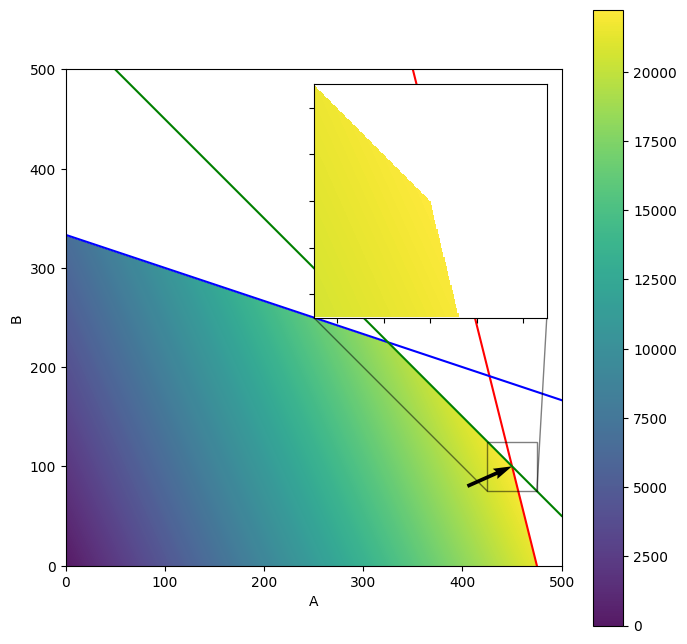

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))

ax.set_xlabel('A')
ax.set_ylabel('B')

rng = 500
ax.set_xlim(0,rng)
ax.set_ylim(0,rng)
n = 2000


d = np.linspace(0,rng, n+1)
X = np.array(np.meshgrid(d,d))
x,y = X

extent=[x.min(), x.max(), y.min(), y.max()]

region_values_ineq = np.einsum('ij,jkl->ikl',A,X)

feasible_region_mask = np.all(region_values_ineq < b.reshape(3,1,1),axis=0)

X_masked = np.zeros_like(X)

X_masked[:, feasible_region_mask] = X[:, feasible_region_mask]

obj_func_val = np.einsum('i,ijk->jk',z,X_masked)

mask = np.ma.masked_where(np.logical_not(feasible_region_mask), obj_func_val)

cm = mplt.cm.viridis
cm.set_bad(color='white')

imshow_cfg = {
    'extent': extent,
    'cmap':cm,
    'origin':'lower',
    'alpha':0.9
    }

map = ax.imshow(mask, **imshow_cfg)
fig.colorbar(map,ax=ax)

for Ai, bi, c in zip(A,b,['r','b','g']):
  ax.axline(xy1=(0,bi/Ai[1]),xy2=(bi/Ai[0],0), color=c)

x1,x2 = 425, 475
y1,y2 = 75, 125
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

axins.imshow(mask,**imshow_cfg)
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.quiver(450,100,z[0],z[1],color='black',pivot='tip',units='x', scale=1)

pass

## c) Resolva o problema de programação linear pelo método simplex;


In [ ]:
# Resolvendo pela nossa implementação do Simplex
# x := vetor solução
# s := vetor de slack variables
# z := valor máximo

x,s,maxv = Simplex.solve(A,b,z)

                     x0   x1        s0   s1         s2    z        b
0th constraint      1.0  0.0  0.066667  0.0  -0.333333  0.0    450.0
1th constraint      0.0  0.0  0.005333  1.0  -0.146667  0.0     10.0
2th constraint      0.0  1.0 -0.066667  0.0   1.333333  0.0    100.0
objective function  0.0  0.0  1.666667  0.0  11.666667  1.0  22250.0


$max_{\substack{Ax \le b \\ x \ge 0}} f(x,y) = 22250 \rightarrow A=450, B=100$

## d) Avalie qual das seguintes opções aumentará mais os lucros: aumentar a quantidade de matéria prima, a capacidade de armazenamento, ou aumentar o tempo de produção.

Como o gradiente é perpendicular as linhas de campo, procuramos o gradiente das inequações que tenha o menor ângulo com o gradiente da função objetivo.

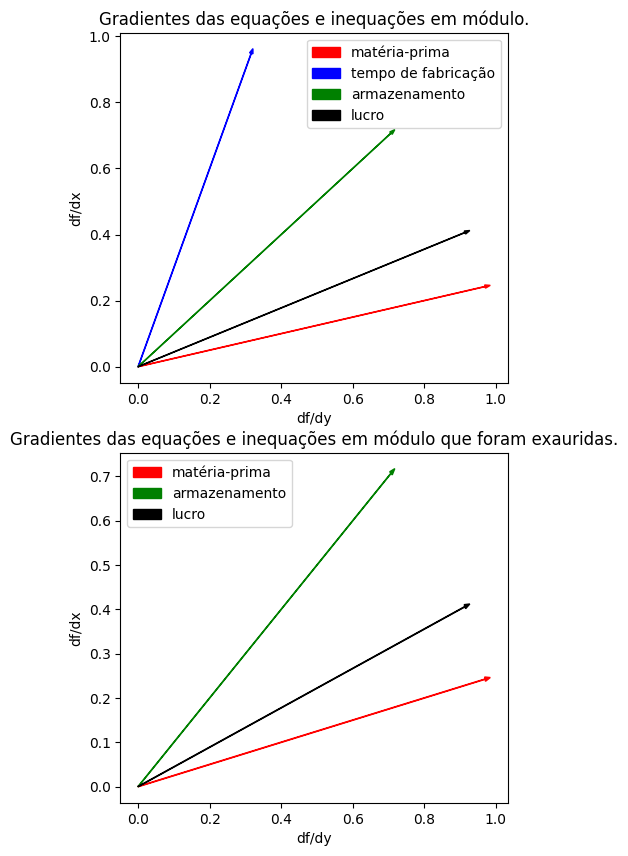

In [ ]:
fig, ax = plt.subplots(2, figsize=(5,10))

Anorm = A.copy()

Anorm = A/np.linalg.norm(A, axis=-1)[:, np.newaxis]
znorm = z/np.linalg.norm(z)

ax[0].arrow(0, 0, Anorm[0,0], Anorm[0,1],head_width=0.01, color='red', label=names[0])
ax[0].arrow(0, 0, Anorm[1,0], Anorm[1,1],head_width=0.01, color='blue', label=names[1])
ax[0].arrow(0, 0, Anorm[2,0], Anorm[2,1],head_width=0.01, color='green', label=names[2])
ax[0].arrow(0,0,znorm[0], znorm[1], head_width=0.01, color='black', label='lucro')
ax[0].legend()
ax[0].set_xlabel('df/dy')
ax[0].set_ylabel('df/dx')
ax[0].set_title('Gradientes das equações e inequações em módulo.')

ax[1].arrow(0, 0, Anorm[0,0], Anorm[0,1],head_width=0.01, color='red', label=names[0])
ax[1].arrow(0, 0, Anorm[2,0], Anorm[2,1],head_width=0.01, color='green', label=names[2])
ax[1].arrow(0,0,znorm[0], znorm[1], head_width=0.01, color='black', label='lucro')
ax[1].legend()
ax[1].set_xlabel('df/dy')
ax[1].set_ylabel('df/dx')
ax[1].set_title('Gradientes das equações e inequações em módulo que foram exauridas.')

pass

In [ ]:
# Valores exauridos

np.array(names)[s == 0]

array(['matéria-prima', 'armazenamento'], dtype='<U19')

In [ ]:
gradiente_exauridas = A
gradiente_func_obj = z

In [ ]:
consine_similarity = [scipy.spatial.distance.cosine(gradiente_func_obj, ge) for ge in gradiente_exauridas]

In [ ]:
idx = np.argmin(consine_similarity)
print('A restrição que daria maior aumento na função objetivo se folgada seria: ', names[np.arange(len(b))[s == 0][idx]])

A restrição que daria maior aumento na função objetivo se folgada seria:  matéria-prima


Removendo cada restrição para testar o resultado

In [ ]:
idx = np.arange(0, len(A))

for i in range(len(A)):
  print('='*20)
  print(f'Removing the {i}th constraint')
  A_sem_restricao = A[idx != i]
  b_sem_restricao = b[idx != i]
  x,s,maxv= Simplex.solve(A_sem_restricao,b_sem_restricao,z,show_tableau=False)
  print(f'Maximized objetive function: {maxv}')

Removing the 0th constraint
Maximized objetive function: 24750.0
Removing the 1th constraint
Maximized objetive function: 22250.0
Removing the 2th constraint
Maximized objetive function: 23045.454545454544


# **Questão 2**

## a) Escreva o problema de programação linear para maximizar o lucro.

$R_{egular}$, $P_{remiun}$, $N_{ovo}$

$7\frac{m^3}{ton}\cdot R + 11\frac{m^3}{ton}\cdot P + 15\frac{m^3}{ton}\cdot N \le 154\frac{m^3}{semana}$

$10\frac{h}{ton}\cdot R + 8\frac{h}{ton}\cdot P + 12\frac{h}{ton}\cdot N \le 80\frac{h}{semana}$

$R \le 9 ton; P \le 6ton; \le 5ton$

Maximize:

$150\frac{R\$}{ton}\cdot R + 175\frac{R\$}{ton}\cdot P + 250\frac{R\$}{ton}\cdot N$

In [ ]:
# Inequacoes no formato Ax <= b
# x = [A,B].T

A = np.r_[
    np.array(
        [
            [7,11,15],
            [10, 8, 12]
        ]), np.eye(3)]

ton = np.array([
    9.0,
    6.0,
    5.0
])

b = np.r_[np.array([
    154,
    80,
]), ton]

# Valor da funcao objetivo dado por f(A,B) = zx
z = np.array([
    150,
    175,
    250
])

names = [
    'gás bruto',
    'tempo de produção',
    'armazenamento regular',
    'armazenamento premium',
    'armazenamento novo'
]

## b) Resolva o problema de programação linear pelo método simplex.

In [ ]:
# Resolvendo pela nossa implementação do Simplex
# x := vetor solução
# s := vetor de slack variables
# z := valor máximo

x,s,maxv = Simplex.solve(A,b,z)

                           x0   x1   x2   s0         s1   s2        s3   s4  \
0th constraint      -5.500000  0.0  0.0  1.0  -1.250000  0.0 -1.000000  0.0   
1th constraint       0.000000  1.0  0.0  0.0   0.000000  0.0  1.000000  0.0   
2th constraint       1.000000  0.0  0.0  0.0   0.000000  1.0  0.000000  0.0   
3th constraint      -0.833333  0.0  0.0  0.0  -0.083333  0.0  0.666667  1.0   
4th constraint       0.833333  0.0  1.0  0.0   0.083333  0.0 -0.666667  0.0   
objective function  58.333333  0.0  0.0  0.0  20.833333  0.0  8.333333  0.0   

                      z            b  
0th constraint      0.0    48.000000  
1th constraint      0.0     6.000000  
2th constraint      0.0     9.000000  
3th constraint      0.0     2.333333  
4th constraint      0.0     2.666667  
objective function  1.0  1716.666667  


<ipython-input-4-f926c3cf0e70>:42: RuntimeWarning: divide by zero encountered in divide
  indicators = b / pivot_column


$max_{\substack{Ax \le b \\ x \ge 0}} f(x,y,z) = 1716.67 \rightarrow x=0, y=6, z=2.67$

## c) Avalie qual das seguintes opções aumentará mais os lucros: aumentar a quantidade de matéria-prima, a capacidade de armazenamento, ou aumentar o tempo de produção.

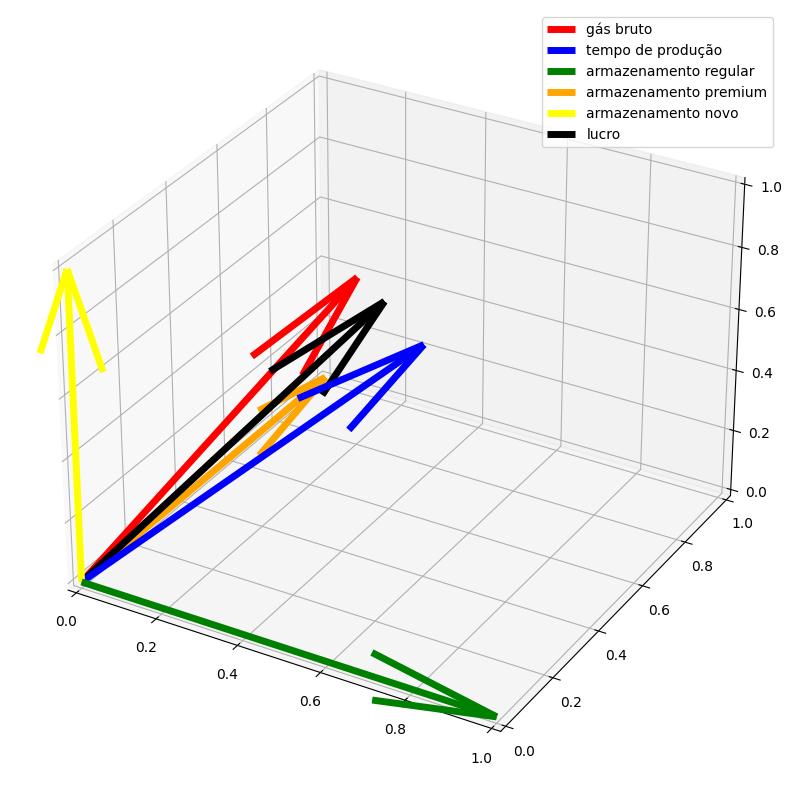

In [ ]:
gradiente = z
gradiente_ineq = A

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

for a,c,name in zip(A, 'red,blue,green,orange,yellow'.split(','), names):
  ax.quiver(0,0,0,a[0],a[1],a[2],length=1,normalize=True,color=c,label=name, linewidths=5)

ax.quiver(0,0,0,z[0],z[1],z[2],normalize=True, color='black', label='lucro', linewidths=5)

ax.legend()

In [ ]:
# Valores exauridos

np.array(names)[s == 0]

array(['tempo de produção', 'armazenamento premium'], dtype='<U21')

In [ ]:
gradiente_exauridas = A[s == 0]
gradiente_func_obj = z

In [ ]:
consine_similarity = [scipy.spatial.distance.cosine(gradiente_func_obj, ge) for ge in gradiente_exauridas]

In [ ]:
idx = np.argmin(consine_similarity)
print('A restrição que daria maior aumento na função objetivo se folgada seria: ', names[np.arange(len(b))[s == 0][idx]])

A restrição que daria maior aumento na função objetivo se folgada seria:  tempo de produção


Removendo a restricao para cada resultado

In [ ]:
idx = np.arange(0, len(A))

for i in range(len(A)):
  print('='*20)
  print(f'Removing the {names[i]} constraint')
  A_sem_restricao = A[idx != i]
  b_sem_restricao = b[idx != i]
  x,s,maxv= Simplex.solve(A_sem_restricao,b_sem_restricao,z, show_tableau=False)
  print(f'Maximized objetive function: {maxv}')

Removing the gás bruto constraint
Maximized objetive function: 1716.6666666666667
Removing the tempo de produção constraint
Maximized objetive function: 2854.5454545454545
Removing the armazenamento regular constraint
Maximized objetive function: 1716.6666666666667
Removing the armazenamento premium constraint
Maximized objetive function: 1750.0
Removing the armazenamento novo constraint
Maximized objetive function: 1716.6666666666667


<ipython-input-4-f926c3cf0e70>:42: RuntimeWarning: divide by zero encountered in divide
  indicators = b / pivot_column


# **Questão 3**


$1.2\cdot x + 2.25\cdot y \le 14$

$x + 1.1\cdot y \le 8$

$2.5\cdot x + y \le 9$

$x,y \ge 0$

Maximize:

$1.75\cdot x + 1.25\cdot y$

In [ ]:
# Formulating the linear program

A = np.array([
    [1.2,2.25],
    [1, 1.1],
    [2.5,1]
])
b = np.array([
    14,
    8,
    9
])
z = np.array([
    1.75,
    1.25
])

## a) Obtenha a solução graficamente.

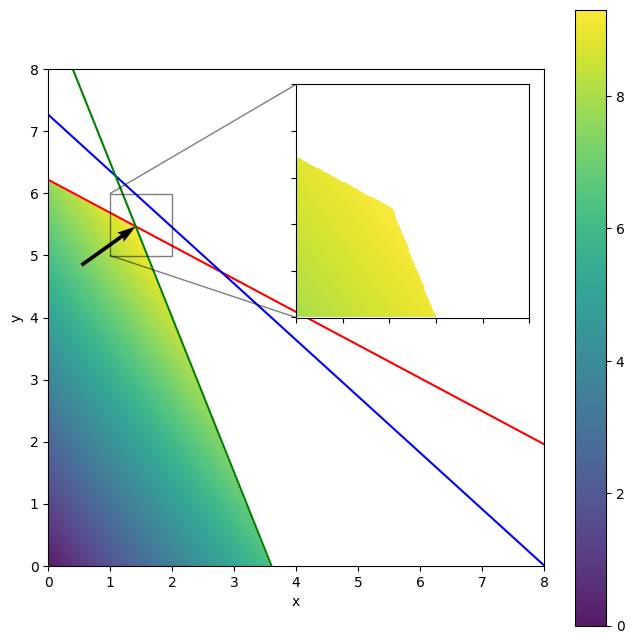

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))

ax.set_xlabel('x')
ax.set_ylabel('y')

rng = 8
ax.set_xlim(0,rng)
ax.set_ylim(0,rng)
n = 2000


d = np.linspace(0,rng, n+1)
X = np.array(np.meshgrid(d,d))
x,y = X

extent=[x.min(), x.max(), y.min(), y.max()]

region_values_ineq = np.einsum('ij,jkl->ikl',A,X)

feasible_region_mask = np.all(region_values_ineq < b.reshape(-1,1,1),axis=0)

X_masked = np.zeros_like(X)

X_masked[:, feasible_region_mask] = X[:, feasible_region_mask]

obj_func_val = np.einsum('i,ijk->jk',z,X_masked)

mask = np.ma.masked_where(np.logical_not(feasible_region_mask), obj_func_val)

cm = mplt.cm.viridis
cm.set_bad(color='white')

imshow_cfg = {
    'extent': extent,
    'cmap':cm,
    'origin':'lower',
    'alpha':0.9
    }

map = ax.imshow(mask, **imshow_cfg)

fig.colorbar(map,ax=ax)

for Ai, bi, c in zip(A,b,['r','b','g']):
  ax.axline(xy1=(0,bi/Ai[1]),xy2=(bi/Ai[0],0), color=c)

x1,x2 = 1, 2
y1,y2 = 5, 6
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

axins.imshow(mask,**imshow_cfg)
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.quiver(1.4124293785310735,5.468926553672316,z[0],z[1],color='black',pivot='tip',units='x', scale=2)

pass

## b) Usando o método simplex

In [ ]:
# Resolvendo pela nossa implementação do Simplex
# x := vetor solução
# s := vetor de slack variables
# z := valor máximo

x,s,maxv = Simplex.solve(A,b,z)

                     x0   x1        s0   s1        s2    z         b
0th constraint      0.0  1.0  0.564972  0.0 -0.271186  0.0  5.468927
1th constraint      0.0  0.0 -0.395480  1.0 -0.210169  0.0  0.571751
2th constraint      1.0  0.0 -0.225989  0.0  0.508475  0.0  1.412429
objective function  0.0  0.0  0.310734  0.0  0.550847  1.0  9.307910


$max_{\substack{Ax \le b \\ x \ge 0}} f(x,y) = 9.307909604519773 \rightarrow x=1.4124293785310735, y=5.468926553672316$

## c) Qual aumento de restrição contribuiria mais para o aumento da função objetivo.

Aplicamos o mesmo conceito do gradiente.

In [ ]:
gradiente = z

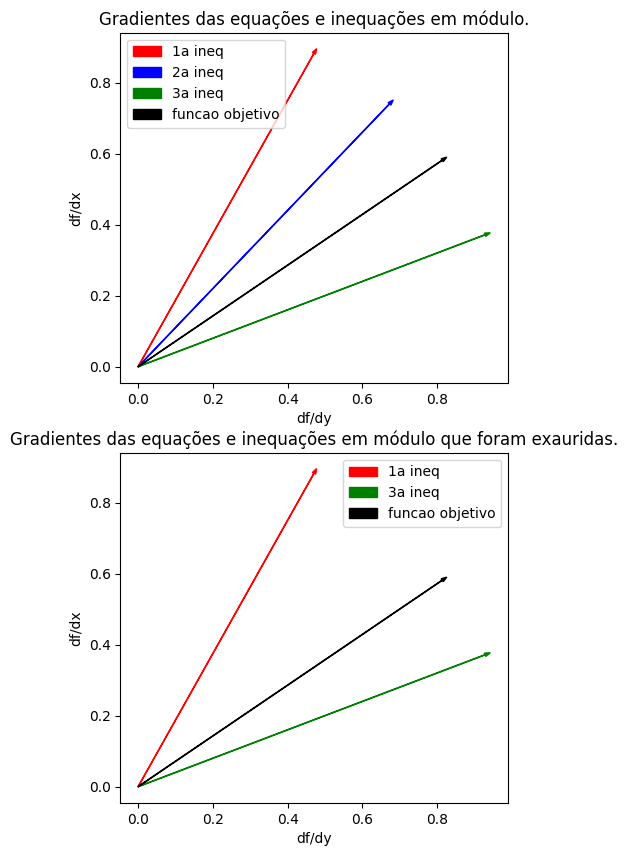

In [ ]:
fig, ax = plt.subplots(2, figsize=(5,10))

Anorm = A.copy()

Anorm = A/np.linalg.norm(A, axis=-1)[:, np.newaxis]
znorm = z/np.linalg.norm(z)

ax[0].arrow(0, 0, Anorm[0,0], Anorm[0,1],head_width=0.01, color='red', label='1a ineq')
ax[0].arrow(0, 0, Anorm[1,0], Anorm[1,1],head_width=0.01, color='blue', label='2a ineq')
ax[0].arrow(0, 0, Anorm[2,0], Anorm[2,1],head_width=0.01, color='green', label='3a ineq')
ax[0].arrow(0,0,znorm[0], znorm[1], head_width=0.01, color='black', label='funcao objetivo')
ax[0].legend()
ax[0].set_xlabel('df/dy')
ax[0].set_ylabel('df/dx')
ax[0].set_title('Gradientes das equações e inequações em módulo.')

ax[1].arrow(0, 0, Anorm[0,0], Anorm[0,1],head_width=0.01, color='red', label='1a ineq')
ax[1].arrow(0, 0, Anorm[2,0], Anorm[2,1],head_width=0.01, color='green', label='3a ineq')
ax[1].arrow(0,0,znorm[0], znorm[1], head_width=0.01, color='black', label='funcao objetivo')
ax[1].legend()
ax[1].set_xlabel('df/dy')
ax[1].set_ylabel('df/dx')
ax[1].set_title('Gradientes das equações e inequações em módulo que foram exauridas.')

pass

In [ ]:
gradiente_exauridas = A[s == 0]
gradiente_func_obj = z

In [ ]:
consine_similarity = [scipy.spatial.distance.cosine(gradiente_func_obj, ge) for ge in gradiente_exauridas]

In [ ]:
idx = np.argmin(consine_similarity)
print('A restrição que daria maior aumento na função objetivo se folgada seria: ', np.arange(len(b))[s == 0][idx] + 1)

A restrição que daria maior aumento na função objetivo se folgada seria:  3


In [ ]:
idx = np.arange(0, len(A))

for i in range(len(A)):
  print('='*20)
  print(f'Removing the {i}th constraint')
  A_sem_restricao = A[idx != i]
  b_sem_restricao = b[idx != i]
  x,s,maxv= Simplex.solve(A_sem_restricao,b_sem_restricao,z,show_tableau=False)
  print(f'Maximized objetive function: {maxv}')

Removing the 0th constraint
Maximized objetive function: 9.757142857142856
Removing the 1th constraint
Maximized objetive function: 9.307909604519773
Removing the 2th constraint
Maximized objetive function: 14.0
